In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import genpareto
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from scipy.stats import loguniform
from scipy.optimize import minimize
import os
import plotly.graph_objects as go

In [32]:
result = dict(np.load('test/stacked_results.npz', allow_pickle=True))

In [33]:
result

{'y_pred': array([0.56294634, 0.55287494, 0.58214951, 0.55862113, 0.54871229,
        0.5459744 , 0.57068439, 0.57905143, 0.58214951, 0.43314583,
        0.515518  , 0.46677605, 0.28914351, 0.29238563, 0.30027681,
        0.43314583, 0.515518  , 0.46677605, 0.79391552, 0.79695316,
        0.86012531, 0.58198525, 0.6320565 , 0.6320565 , 0.56294634,
        0.55287494, 0.58214951, 0.55862113, 0.54871229, 0.5459744 ,
        0.57068439, 0.57905143, 0.58214951, 0.42222273, 0.89854674,
        1.26077536, 0.32249945, 0.33262364, 0.33133665, 0.42222273,
        0.89854674, 1.26077536, 0.47832647, 0.49530106, 0.53684912,
        0.54463059, 0.56346861, 0.56184236, 0.51083842, 0.51615515,
        0.49396035, 0.42326842, 0.40848568, 0.43009824, 0.43597374,
        0.40805019, 0.49396035, 0.42222273, 0.89854674, 1.26077536,
        0.32249945, 0.33262364, 0.33133665, 0.42222273, 0.89854674,
        1.26077536, 0.47832647, 0.49530106, 0.53684912, 0.54463059,
        0.56346861, 0.56184236, 0.5108

In [34]:
#actual = result['actual']
forecasted = result['y_pred']

In [35]:
sample_size = len(actual)
sample_size

NameError: name 'actual' is not defined

In [36]:
# Flatten the original test data for comparison
#original_series = actual

# Create the plotly graph
fig = go.Figure()

# fig.add_trace(go.Scatter(
#     y=original_series,
#     mode='lines',
#     name='Original Series'
# ))

fig.add_trace(go.Scatter(
    y=forecasted,
    mode='lines',
    name='Decoded Series',
    opacity=0.7
))

fig.update_layout(
    title='Original Series vs Decoded Series',
    xaxis_title='Time Index',
    yaxis_title='Value',
    legend=dict(x=0, y=1)
)

fig.show()

In [ ]:
residuals = actual - forecasted

In [ ]:
# Convert to DataFrame and name the column
residuals_df = pd.DataFrame(residuals, columns=['residuals'])

# Ensure there are no non-finite values
residuals_df = residuals_df[np.isfinite(residuals_df['residuals'])]

In [ ]:
residuals_df

,residuals
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
1608,-0.020778
1609,-0.042057
1610,-0.032248
1611,0.050838


In [ ]:
# Automatically determine the threshold using the Peak Over Threshold (POT) method
def pot_threshold(residuals, quantile=0.95):
    return np.quantile(residuals, quantile)

# Fit the Generalized Pareto Distribution (GPD)
def fit_gpd(residuals, threshold):
    excesses = residuals[residuals > threshold] - threshold
    params = genpareto.fit(excesses)
    return params, excesses

In [ ]:
# Fit the GPD to the residuals
threshold = pot_threshold(residuals_df['residuals'], quantile=0.95)
params, excesses = fit_gpd(residuals_df['residuals'], threshold)

In [ ]:
# Function to identify anomalies using the fitted GPD
def detect_anomalies(residuals, params, threshold):
    c, loc, scale = params
    gpd_threshold = genpareto.ppf(0.80, c, loc=loc, scale=scale)
    return residuals > (threshold + gpd_threshold)

In [ ]:
# Detect anomalies in the residual series
anomalies = detect_anomalies(residuals_df['residuals'], params, threshold)

In [ ]:
anomalies

0       False
1       False
2       False
3       False
4       False
        ...  
1608    False
1609    False
1610    False
1611    False
1612    False
Name: residuals, Length: 1613, dtype: bool

In [ ]:
# Count the number of anomalies detected
num_anomalies = anomalies.sum()
print(f"Number of anomalies detected: {num_anomalies}")

Number of anomalies detected: 8


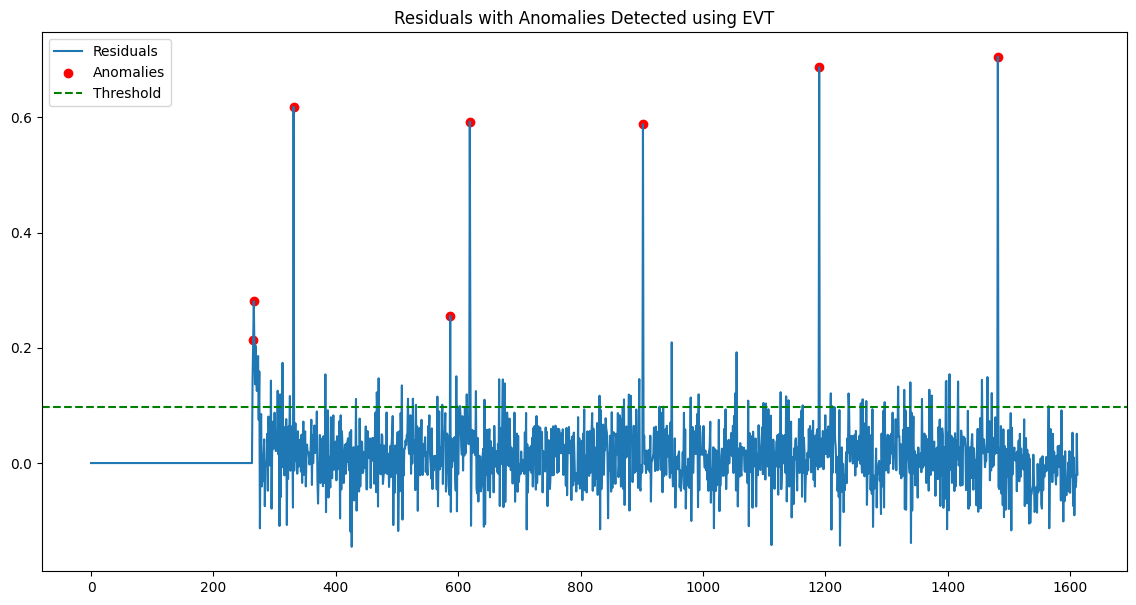

In [ ]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(residuals_df['residuals'], label='Residuals')
plt.scatter(residuals_df.index[anomalies], residuals_df['residuals'][anomalies], color='red', label='Anomalies')
plt.axhline(y=threshold, color='green', linestyle='--', label='Threshold')
plt.legend()
plt.title('Residuals with Anomalies Detected using EVT')
plt.show()

In [ ]:
# Assuming anomalies is a boolean array with the same length as the residuals
anomaly_indices = np.where(anomalies)[0]
anomaly_values = original_series[anomaly_indices]

In [ ]:
# Create the Plotly graph
fig = go.Figure()

fig.add_trace(go.Scatter(
    y=original_series,
    mode='lines',
    name='Original Series'
))

fig.add_trace(go.Scatter(
    y=forecasted,
    mode='lines',
    name='Decoded Series',
    opacity=0.7
))

# Add anomalies to the plot
fig.add_trace(go.Scatter(
    x=anomaly_indices,
    y=anomaly_values,
    mode='markers',
    name='Anomalies',
    marker=dict(color='red', size=8, symbol='cross')
))

fig.update_layout(
    title='Original Series vs Decoded Series with Anomalies',
    xaxis_title='Time Index',
    yaxis_title='Value',
    legend=dict(x=0, y=1)
)

fig.show()